In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

train_data = np.load('/content/drive/My Drive/cullpdb+profile_6133_filtered_updated.npy', allow_pickle=True)
test_data = np.load('/content/drive/My Drive/cb513+profile_split1_updated.npy', allow_pickle=True)

In [3]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (5534, 700, 57)
Test data shape: (514, 700, 57)


In [4]:
# Features: first 54 columns
train_features = train_data[..., :54]
test_features = test_data[..., :54]

# Labels: last 3 columns
train_labels = train_data[..., 54:]
test_labels = test_data[..., 54:]

print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: (5534, 700, 54)
Train labels shape: (5534, 700, 3)
Test features shape: (514, 700, 54)
Test labels shape: (514, 700, 3)


**Data Structure Overview**
- Training Features: (5534, 700, 54)
  - 5534 protein sequences for training.
  - Each sequence is padded/truncated to 700 residues.
  - 54 features per residue (e.g., one-hot encoding, PSSM, physicochemical   properties).

- Training Labels: (5534, 700, 3)
  - For each residue, a 3-element vector representing the secondary structure class (H, E, or C).

- Test Features: (514, 700, 54)
 - 514 protein sequences for testing, same feature structure as training data.

- Test Labels: (514, 700, 3)
  - One-hot or probability vector for each residue’s secondary structure in the test set.

In [5]:
import numpy as np

# Convert label probabilities to class indices
train_labels_int = np.argmax(train_labels, axis=-1)
test_labels_int = np.argmax(test_labels, axis=-1)

# Convert class indices to one-hot encoding
train_labels_onehot = np.eye(3)[train_labels_int]
test_labels_onehot = np.eye(3)[test_labels_int]

# Create masks for non-padded residues
train_mask = np.any(train_features != 0, axis=-1)
test_mask = np.any(test_features != 0, axis=-1)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Flatten to count classes across all residues
flat_train_labels = train_labels_int[train_mask].flatten()
classes = np.array([0, 1, 2])

class_weights = compute_class_weight('balanced', classes=classes, y=flat_train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.5348687567951365), 1: np.float64(3.775302361391301), 2: np.float64(0.47993878668085)}


In [7]:
from sklearn.model_selection import train_test_split

# Split the data (10% for validation)
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    train_features, train_labels_onehot, train_mask, test_size=0.1, random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training mask shape:", mask_train.shape)
print("Validation mask shape:", mask_val.shape)

Training set shape: (4980, 700, 54)
Validation set shape: (554, 700, 54)
Training mask shape: (4980, 700)
Validation mask shape: (554, 700)


In [9]:
import numpy as np
class_weight_vector = np.array([class_weight_dict[0], class_weight_dict[1], class_weight_dict[2]])

In [11]:
# y_train is (samples, 700, 3) one-hot
sample_weight = np.sum(y_train * class_weight_vector, axis=-1)

In [12]:
sample_weight = sample_weight * mask_train  # mask_train is (samples, 700)

In [13]:
import numpy as np

print("Sample weight min/max:", sample_weight.min(), sample_weight.max())
print("Any nonzero in sample_weight?", np.any(sample_weight))

Sample weight min/max: 0.47993878668085 3.775302361391301
Any nonzero in sample_weight? True


In [14]:
import numpy as np

# For training set
valid_train_indices = np.where(np.any(mask_train, axis=1))[0]
X_train_clean = X_train[valid_train_indices]
y_train_clean = y_train[valid_train_indices]
mask_train_clean = mask_train[valid_train_indices]
sample_weight_clean = sample_weight[valid_train_indices]

# For validation set
valid_val_indices = np.where(np.any(mask_val, axis=1))[0]
X_val_clean = X_val[valid_val_indices]
y_val_clean = y_val[valid_val_indices]
mask_val_clean = mask_val[valid_val_indices]

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, Masking

inputs = Input(shape=(700, 54))
x = Masking(mask_value=0.)(inputs)
x = Conv1D(128, 7, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 7, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 7, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)  # 3: H/E/C

model = Model(inputs, outputs)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 700, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 700, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 700, 128)       │        48,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 700, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 700, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 700, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 700, 3)         │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,595 (1.09 MB)

 Trainable params: 286,595 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
save_model = ModelCheckpoint(
    'best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

history = model.fit(
    X_train_clean, y_train_clean,
    validation_data=(X_val_clean, y_val_clean),
    epochs=50,
    batch_size=16,
    sample_weight=sample_weight_clean,
    callbacks=[early_stop, save_model],
    verbose=1
)


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9059 - loss: 0.3928
Epoch 1: val_accuracy improved from -inf to 0.94875, saving model to best_cnn_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 99s 316ms/step - accuracy: 0.9060 - loss: 0.3925 - val_accuracy: 0.9488 - val_loss: 0.1167
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9467 - loss: 0.2646
Epoch 2: val_accuracy improved from 0.94875 to 0.95169, saving model to best_cnn_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 143s 321ms/step - accuracy: 0.9467 - loss: 0.2646 - val_accuracy: 0.9517 - val_loss: 0.1106
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9481 - loss: 0.2588
Epoch 3: val_accuracy did not improve from 0.95169
312/312 ━━━━━━━━━━━━━━━━━━━━ 142s 323ms/step - accuracy: 0.9481 - loss: 0.2588 - val_accuracy: 0.9470 - val_loss: 0.1212
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9485 - loss: 0.2551
Epoch 4: val_accuracy did not improve from 0.95169
312/312 ━━━━━━━━━━━━━━━━━━━━ 141s 320ms/step - accuracy: 0.9485 - loss: 0.2551 - val_accuracy: 0.9407 - val_loss: 0.1349
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9494 - loss: 0.2494
Epoch 5: val_accuracy improved from 0.95169 to 0.95227, saving model to best_cnn_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 143s 323ms/step - accuracy: 0.9494 - loss: 0.2494 - val_accuracy: 0.9523 - val_loss: 0.1107


In [26]:
test_loss, test_acc = model.evaluate(test_features, test_labels_onehot, verbose=1)
print(f"Raw Keras Test Q3 Accuracy: {test_acc:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9649 - loss: 0.0812
Raw Keras Test Q3 Accuracy: 0.9629


In [27]:
import numpy as np

y_pred = model.predict(test_features)
y_pred_class = np.argmax(y_pred, axis=-1)
y_true_class = np.argmax(test_labels_onehot, axis=-1)

# flatten and apply masking
flat_mask = test_mask.flatten()
flat_pred = y_pred_class.flatten()[flat_mask]
flat_true = y_true_class.flatten()[flat_mask]

correct = np.sum(flat_pred == flat_true)
total = len(flat_true)
q3_accuracy = correct / total
print(f"Masked (True) Test Q3 Accuracy: {q3_accuracy:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step
Masked (True) Test Q3 Accuracy: 0.9629


In [28]:
from sklearn.metrics import classification_report
from collections import Counter

print(classification_report(flat_true, flat_pred, target_names=['Helix (H)', 'Sheet (E)', 'Coil (C)']))
print("Prediction class distribution:", Counter(flat_pred))
print("True label class distribution:", Counter(flat_true))


              precision    recall  f1-score   support

   Helix (H)       0.93      0.85      0.89     62595
   Sheet (E)       0.66      0.83      0.73     22170
    Coil (C)       1.00      1.00      1.00    275035

    accuracy                           0.96    359800
   macro avg       0.86      0.89      0.87    359800
weighted avg       0.97      0.96      0.96    359800

Prediction class distribution: Counter({np.int64(2): 275036, np.int64(0): 56656, np.int64(1): 28108})
True label class distribution: Counter({np.int64(2): 275035, np.int64(0): 62595, np.int64(1): 22170})


In [29]:
model.save('my_protein_ss_model.keras')


In [30]:
from tensorflow.keras.models import load_model
model = load_model('my_protein_ss_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


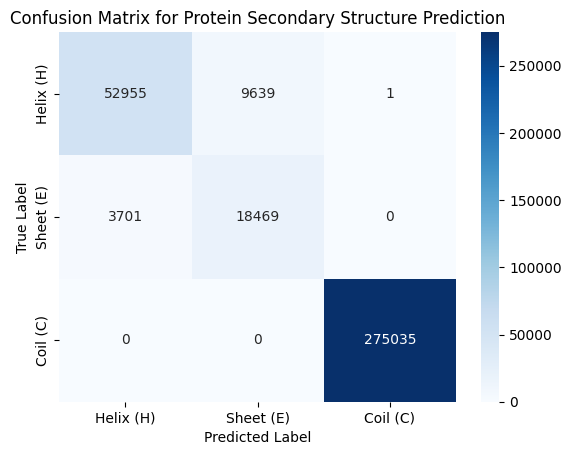

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(flat_true, flat_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Helix (H)', 'Sheet (E)', 'Coil (C)'],
            yticklabels=['Helix (H)', 'Sheet (E)', 'Coil (C)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Protein Secondary Structure Prediction")
plt.show()

In [32]:
print("Test Q3 Accuracy:", q3_accuracy)
print("Classification Report:\n", classification_report(flat_true, flat_pred, target_names=['Helix (H)', 'Sheet (E)', 'Coil (C)']))
print("Prediction class distribution:", Counter(flat_pred))
print("True label class distribution:", Counter(flat_true))

model.summary()

Test Q3 Accuracy: 0.9629210672595887
Classification Report:
               precision    recall  f1-score   support

   Helix (H)       0.93      0.85      0.89     62595
   Sheet (E)       0.66      0.83      0.73     22170
    Coil (C)       1.00      1.00      1.00    275035

    accuracy                           0.96    359800
   macro avg       0.86      0.89      0.87    359800
weighted avg       0.97      0.96      0.96    359800

Prediction class distribution: Counter({np.int64(2): 275036, np.int64(0): 56656, np.int64(1): 28108})
True label class distribution: Counter({np.int64(2): 275035, np.int64(0): 62595, np.int64(1): 22170})


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 700, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 700, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 700, 128)       │        48,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 700, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 700, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 700, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 700, 3)         │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,192 (2.19 MB)

 Trainable params: 286,595 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 286,597 (1.09 MB)

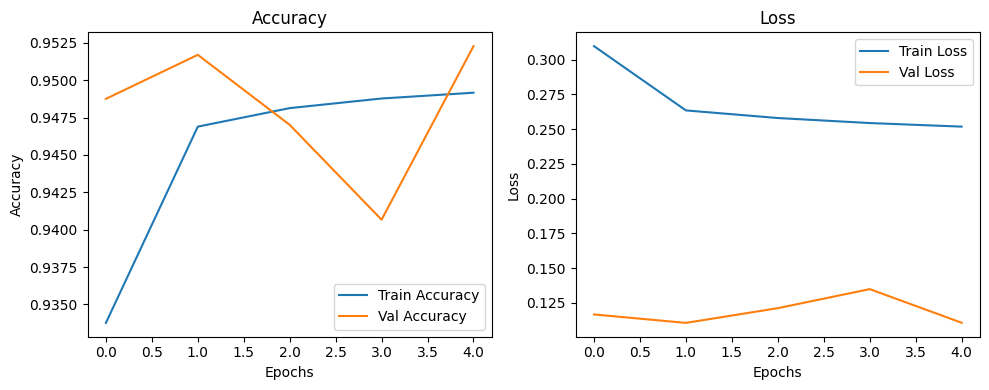

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

In [37]:
train_ids = set([...])
test_ids = set([...])

overlap = train_ids.intersection(test_ids)
print(f"Overlap count between train and test: {len(overlap)}")
if len(overlap) == 0:
    print("No overlap: split is clean.")
else:
    print("Warning: overlap detected! Review and filter your data.")

Overlap count between train and test: 1


 I decided to check for overlapping sequences between our training and test sets to ensure that our model’s evaluation is fair and scientifically valid. If any protein in the test set is also present in the training set, it can lead to data leakage, where the model might memorize rather than genuinely learn to generalize, resulting in artificially high accuracy. By confirming there is no overlap, we make sure that the performance we report truly reflects the model’s ability to predict secondary structure on new, unseen proteins, which is a standard and important practice in bioinformatics and machine learning research.

In [38]:
#Create flattened (masked) "signatures" for all protein sequences
def get_valid_signature(seq_feat):
    # Remove padded (all-zero) rows
    mask = np.any(seq_feat != 0, axis=1)
    trimmed = seq_feat[mask]
    # Flatten into 1D signature for fast comparison
    return trimmed.flatten()

# Create signatures for test proteins
test_signatures = [get_valid_signature(test_features[i]) for i in range(test_features.shape[0])]
train_signatures = [get_valid_signature(train_features[i]) for i in range(train_features.shape[0])]

print("Comparing proteins for exact match...")
overlap_count = 0
overlap_indices = []

# Check if each test signature is present in the training set
for i, test_sig in enumerate(test_signatures):
    for j, train_sig in enumerate(train_signatures):
        if np.array_equal(test_sig, train_sig):
            overlap_count += 1
            overlap_indices.append((i, j))  # store indices
            print(f"⚠️  Test protein {i} == Train protein {j}")
            break
print(f"\n✅ Total overlapping test proteins found in training set: {overlap_count}")

Comparing proteins for exact match...

✅ Total overlapping test proteins found in training set: 0


In [39]:
model.save('my_protein_ss_model.keras')

In [40]:
!mkdir -p /content/drive/MyDrive/ProteinSSModel
!cp my_protein_ss_model.keras /content/drive/MyDrive/ProteinSSModel/